In [2]:
# Загрузка датасета с kaggle
import kagglehub
abtabm_multiclassimagedatasetairplanecar_path = kagglehub.dataset_download('abtabm/multiclassimagedatasetairplanecar')

print('Данные загружены')


100%|██████████| 333M/333M [00:30<00:00, 11.3MB/s] 

Extracting files...


Данные загружены


In [25]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [38]:
data_dir = "../kaggle/input/multiclassimagedatasetairplanecar/Dataset"

In [31]:
# Выбор устройства: GPU если доступен, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Основные параметры
data_dir = "dataset"         # Корневая директория, содержащая 'train' и 'test'
batch_size = 64              # Размер мини-батча
image_size = 224             # Размер входного изображения (ResNet требует 224x224)

In [32]:
# Трансформации для обучающих данных: аугментация + нормализация
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),       # Приведение к нужному размеру
    transforms.RandomHorizontalFlip(),                 # Случайное отражение
    transforms.ColorJitter(),                          # Случайные изменения яркости, контраста, насыщенности и оттенка
    transforms.RandomRotation(30),                     # Случайный поворот
    transforms.ToTensor(),                             # Преобразование в тензор
    transforms.Normalize([0.485, 0.456, 0.406],        # Нормализация под ImageNet
                         [0.229, 0.224, 0.225])
])

# Трансформации для теста/валидации: только resize и нормализация
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [39]:
# Загрузка всех обучающих изображений
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)

# Разделение на обучающую (80%) и валидационную (20%) части
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Загрузка тестового датасета
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Список классов (по названиям папок)
class_names = full_train_dataset.classes
num_classes = len(class_names)

# Предобученная модель

## Первая попытка

In [40]:
# Модель ResNet
# Загрузка предобученной модели ResNet18
model_pr = models.resnet18(pretrained=True)

# Замена последнего слоя (выходов столько, сколько у нас классов)
model_pr.fc = nn.Linear(model_pr.fc.in_features, num_classes)

# Перенос модели на GPU/CPU
model_pr = model_pr.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [41]:
criterion = nn.CrossEntropyLoss()   # Функция потерь: кросс-энтропия для многоклассовой классификации

optimizer = optim.Adam(model_pr.parameters(), lr=1e-4, weight_decay=1e-5)   # Оптимизатор: Adam с небольшим learning rate

num_epochs = 10   # Количество эпох

In [42]:
# Scheduler: снижает learning rate, если val_loss не улучшается
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [43]:
# Для визуализации: храним потери и точности
train_losses, val_losses, val_accuracies = [], [], []

# Цикл обучения
for epoch in range(num_epochs):
    model_pr.train()  # Перевод в режим обучения
    running_loss = 0.0

    # Обучающая эпоха
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model_pr(inputs)
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Суммируем потери
        running_loss += loss.item() * inputs.size(0)

    # Средняя потеря за эпоху
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Валидация
    model_pr.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_pr(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step(epoch_val_loss)

Epoch 1/10: 100%|██████████| 38/38 [00:45<00:00,  1.19s/it]


Train Loss: 0.1271, Val Loss: 0.0198, Val Acc: 0.9950


Epoch 2/10: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]


Train Loss: 0.0147, Val Loss: 0.0382, Val Acc: 0.9883


Epoch 3/10: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


Train Loss: 0.0089, Val Loss: 0.0120, Val Acc: 0.9983


Epoch 4/10: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]


Train Loss: 0.0089, Val Loss: 0.0156, Val Acc: 0.9983


Epoch 5/10: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


Train Loss: 0.0039, Val Loss: 0.0244, Val Acc: 0.9967


Epoch 6/10: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Train Loss: 0.0040, Val Loss: 0.0169, Val Acc: 0.9950


Epoch 7/10: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Train Loss: 0.0029, Val Loss: 0.0097, Val Acc: 0.9983


Epoch 8/10: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Train Loss: 0.0027, Val Loss: 0.0208, Val Acc: 0.9950


Epoch 9/10: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Train Loss: 0.0018, Val Loss: 0.0169, Val Acc: 0.9967


Epoch 10/10: 100%|██████████| 38/38 [00:38<00:00,  1.03s/it]


Train Loss: 0.0032, Val Loss: 0.0193, Val Acc: 0.9917


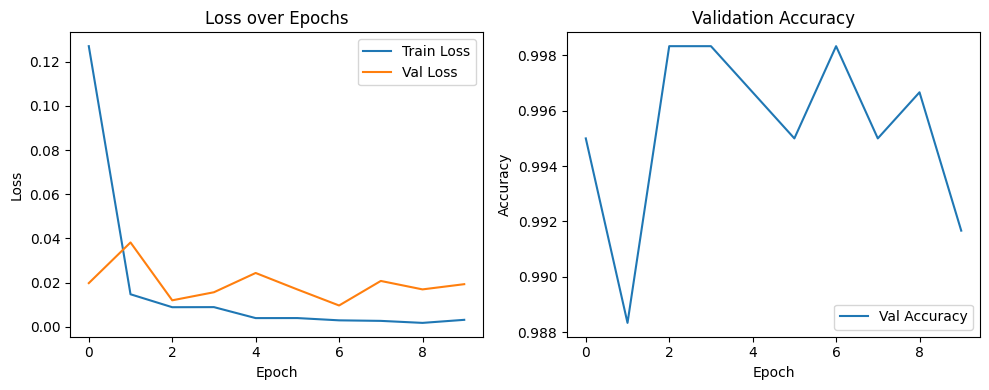

In [47]:
# Построение графиков потерь и точности
plt.figure(figsize=(10, 4))

# Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# Оценка на тестовых данных
model_pr.eval()
y_true, y_pred = [], []

# Получение предсказаний
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_pr(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Матрица ошибок и подробный отчет
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
[[186   2   1]
 [  0 193   0]
 [  0   0 200]]

Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.98      0.99       189
         car       0.99      1.00      0.99       193
        ship       1.00      1.00      1.00       200

    accuracy                           0.99       582
   macro avg       0.99      0.99      0.99       582
weighted avg       0.99      0.99      0.99       582



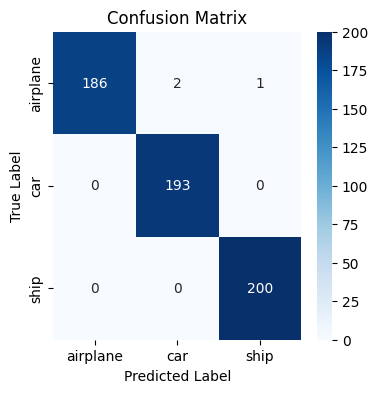

In [50]:
import seaborn as sns

# Визуализация матрицы ошибок
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [45]:
torch.save(model_pr.state_dict(), "/content/drive/MyDrive/Colab Notebooks/CV_LAB4_DATA/model_pred.pth")

## Вторая попытка

In [ ]:
batch_size = 32

# Загрузка всех обучающих изображений
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)

# Разделение на обучающую (80%) и валидационную (20%) части
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Загрузка тестового датасета
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Список классов (по названиям папок)
class_names = full_train_dataset.classes
num_classes = len(class_names)

In [ ]:
# Модель ResNet
# Загрузка предобученной модели ResNet18
model = models.resnet18(pretrained=True)

# Замена последнего слоя (выходов столько, сколько у нас классов)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Перенос модели на GPU/CPU
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()   # Функция потерь: кросс-энтропия для многоклассовой классификации

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)   # Оптимизатор: Adam с небольшим learning rate

num_epochs = 10   # Количество эпох

In [ ]:
# Scheduler: снижает learning rate, если val_loss не улучшается
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

In [ ]:
# Для визуализации: храним потери и точности
train_losses, val_losses, val_accuracies = [], [], []

# Цикл обучения
for epoch in range(num_epochs):
    model.train()  # Перевод в режим обучения
    running_loss = 0.0

    # Обучающая эпоха
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Суммируем потери
        running_loss += loss.item() * inputs.size(0)

    # Средняя потеря за эпоху
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)



    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step(epoch_val_loss)

Epoch 1/10: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s]


Train Loss: 0.0106, Val Loss: 0.0111, Val Acc: 0.9950


Epoch 2/10: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]


Train Loss: 0.0087, Val Loss: 0.0049, Val Acc: 0.9983


Epoch 3/10: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s]


Train Loss: 0.0238, Val Loss: 0.0168, Val Acc: 0.9917


Epoch 4/10: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]


Train Loss: 0.0087, Val Loss: 0.0300, Val Acc: 0.9850


Epoch 5/10: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s]


Train Loss: 0.0077, Val Loss: 0.0026, Val Acc: 1.0000


Epoch 6/10: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]


Train Loss: 0.0046, Val Loss: 0.0044, Val Acc: 0.9983


Epoch 7/10: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s]


Train Loss: 0.0050, Val Loss: 0.0097, Val Acc: 0.9983


Epoch 8/10: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s]


Train Loss: 0.0095, Val Loss: 0.0034, Val Acc: 1.0000


Epoch 9/10: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s]


Train Loss: 0.0059, Val Loss: 0.0051, Val Acc: 0.9983


Epoch 10/10: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s]


Train Loss: 0.0041, Val Loss: 0.0069, Val Acc: 0.9950


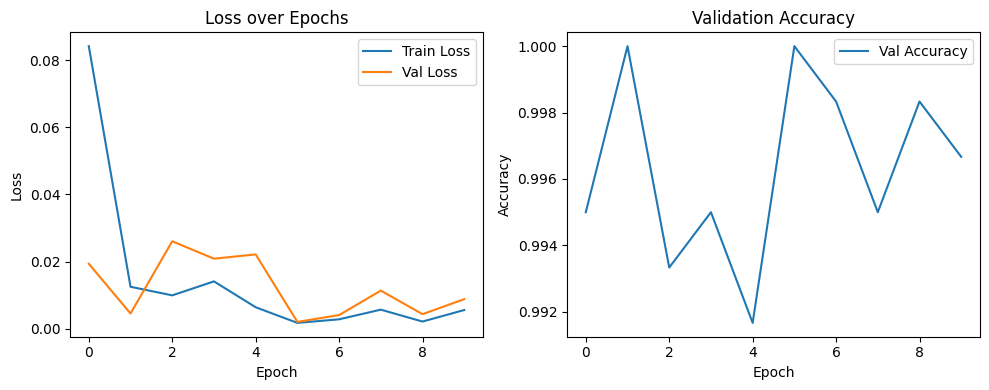

In [ ]:
# Построение графиков потерь и точности
plt.figure(figsize=(10, 4))

# Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Оценка на тестовых данных
model.eval()
y_true, y_pred = [], []

# Получение предсказаний
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Матрица ошибок и подробный отчет
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
[[187   2   0]
 [  0 193   0]
 [  0   0 200]]

Classification Report:
              precision    recall  f1-score   support

   airplanes       1.00      0.99      0.99       189
        cars       0.99      1.00      0.99       193
        ship       1.00      1.00      1.00       200

    accuracy                           1.00       582
   macro avg       1.00      1.00      1.00       582
weighted avg       1.00      1.00      1.00       582



In [ ]:
conf_matrix = [[187,  2,   0],
               [  0, 193,   0],
               [  0,   0, 200]]
class_names = {"airplanes", "cars", "ship"}

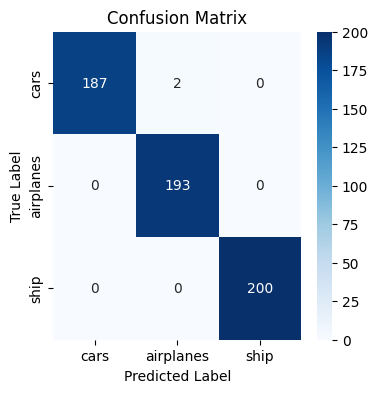

In [ ]:
import seaborn as sns

# Визуализация матрицы ошибок
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Без предобучения

## Первая попытка

In [ ]:
# Основные библиотеки PyTorch
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Метрики и визуализация
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Удобный прогресс-бар

In [ ]:
# Выбор устройства: GPU если доступен, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Основные параметры
data_dir = "dataset"         # Корневая директория, содержащая 'train' и 'test'
batch_size = 64              # Размер мини-батча
image_size = 224             # Размер входного изображения (ResNet требует 224x224)

In [ ]:
# Трансформации для обучающих данных: аугментация + нормализация
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),       # Приведение к нужному размеру
    transforms.RandomHorizontalFlip(),                 # Случайное отражение
    transforms.ColorJitter(),                          # Случайные изменения яркости, контраста, насыщенности и оттенка
    transforms.RandomRotation(30),                     # Случайный поворот
    transforms.ToTensor(),                             # Преобразование в тензор
    transforms.Normalize([0.485, 0.456, 0.406],        # Нормализация под ImageNet
                         [0.229, 0.224, 0.225])
])

# Трансформации для теста/валидации: только resize и нормализация
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = "../kaggle/input/multiclassimagedatasetairplanecar/Dataset"

In [ ]:
# Загрузка всех обучающих изображений
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)

# Разделение на обучающую (80%) и валидационную (20%) части
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Загрузка тестового датасета
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Список классов (по названиям папок)
class_names = full_train_dataset.classes
num_classes = len(class_names)

In [ ]:
# Модель ResNet
# Загрузка предобученной модели ResNet18
model_npr = models.resnet18(weights=None)

# Замена последнего слоя (выходов столько, сколько у нас классов)
model_npr.fc = nn.Linear(model_npr.fc.in_features, num_classes)

# Перенос модели на GPU/CPU
model_npr = model_npr.to(device)

In [ ]:
сriterion = nn.CrossEntropyLoss()   # Функция потерь: кросс-энтропия для многоклассовой классификации

optimizer = optim.Adam(model_npr.parameters(), lr=1e-4, weight_decay=1e-5)   # Оптимизатор: Adam с небольшим learning rate

num_epochs = 10   # Количество эпох

In [ ]:
# Scheduler: снижает learning rate, если val_loss не улучшается
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Для визуализации: храним потери и точности
train_losses, val_losses, val_accuracies = [], [], []

# Цикл обучения
for epoch in range(num_epochs):
    model_npr.train()  # Перевод в режим обучения
    running_loss = 0.0

    # Обучающая эпоха
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model_npr(inputs)
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Суммируем потери
        running_loss += loss.item() * inputs.size(0)

    # Средняя потеря за эпоху
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Валидация
    model_npr.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_npr(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    if phase == 'test':
      scheduler.step(epoch_loss)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/10: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Train Loss: 0.5472, Val Loss: 1.1059, Val Acc: 0.6133


Epoch 2/10: 100%|██████████| 38/38 [00:48<00:00,  1.28s/it]


Train Loss: 0.3100, Val Loss: 0.2888, Val Acc: 0.8917


Epoch 3/10: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Train Loss: 0.2658, Val Loss: 0.3021, Val Acc: 0.8950


Epoch 4/10: 100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Train Loss: 0.2084, Val Loss: 0.3094, Val Acc: 0.8833


Epoch 5/10: 100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Train Loss: 0.1724, Val Loss: 0.2765, Val Acc: 0.8983


Epoch 6/10: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Train Loss: 0.1588, Val Loss: 0.1962, Val Acc: 0.9317


Epoch 7/10: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Train Loss: 0.1483, Val Loss: 0.2453, Val Acc: 0.8967


Epoch 8/10: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Train Loss: 0.1217, Val Loss: 0.1746, Val Acc: 0.9417


Epoch 9/10: 100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Train Loss: 0.1120, Val Loss: 0.1790, Val Acc: 0.9417


Epoch 10/10: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Train Loss: 0.1103, Val Loss: 0.1705, Val Acc: 0.9467


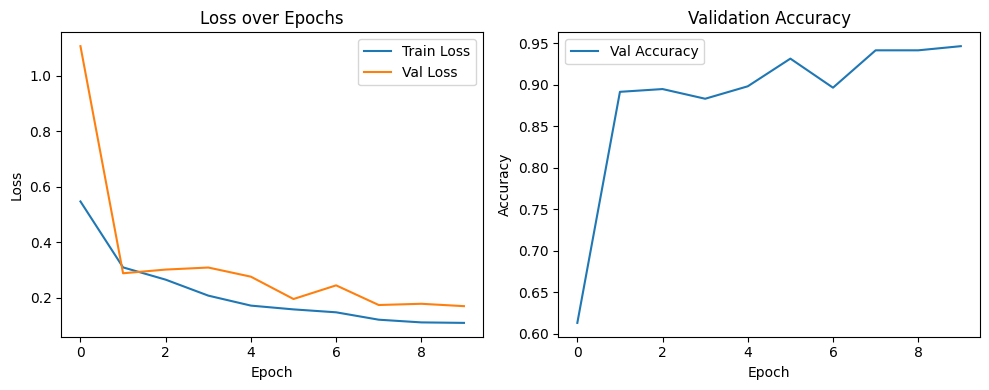

In [ ]:
# Построение графиков потерь и точности
plt.figure(figsize=(10, 4))

# Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Оценка на тестовых данных
model_npr.eval()
y_true, y_pred = [], []

# Получение предсказаний
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_npr(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Матрица ошибок и подробный отчет
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
[[173  11   5]
 [  9 184   0]
 [  5   3 192]]

Classification Report:
              precision    recall  f1-score   support

   airplanes       0.93      0.92      0.92       189
        cars       0.93      0.95      0.94       193
        ship       0.97      0.96      0.97       200

    accuracy                           0.94       582
   macro avg       0.94      0.94      0.94       582
weighted avg       0.94      0.94      0.94       582



In [ ]:
conf_matrix = [[173,  11,   5],
               [  9, 184,   0],
               [  5,   3, 192]]
class_names = {"airplanes", "cars", "ship"}

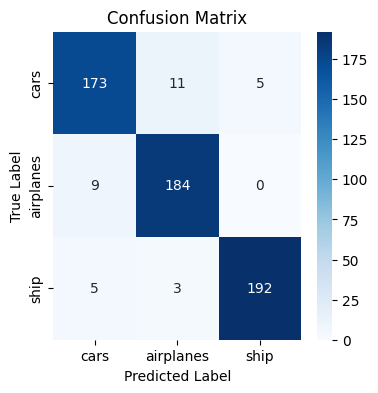

In [ ]:
import seaborn as sns

# Визуализация матрицы ошибок
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
torch.save(model_npr.state_dict(), "/content/drive/MyDrive/Colab Notebooks/CV_LAB4_DATA/model_nopred.pth")

## Вторая попытка

In [11]:
# Модель ResNet
# Загрузка предобученной модели ResNet18
model_npr = models.resnet18(weights=None)

# Замена последнего слоя (выходов столько, сколько у нас классов)
model_npr.fc = nn.Linear(model_npr.fc.in_features, num_classes)

# Перенос модели на GPU/CPU
model_npr = model_npr.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()   # Функция потерь: кросс-энтропия для многоклассовой классификации

optimizer = optim.Adam(model_npr.parameters(), lr=1e-4, weight_decay=1e-5)   # Оптимизатор: Adam с небольшим learning rate

num_epochs = 10   # Количество эпох

In [13]:
# Scheduler: снижает learning rate, если val_loss не улучшается
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# Для визуализации: храним потери и точности
train_losses, val_losses, val_accuracies = [], [], []

# Цикл обучения
for epoch in range(num_epochs):
    model_npr.train()  # Перевод в режим обучения
    running_loss = 0.0

    # Обучающая эпоха
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model_npr(inputs)
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Суммируем потери
        running_loss += loss.item() * inputs.size(0)

    # Средняя потеря за эпоху
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Валидация
    model_npr.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_npr(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step(epoch_val_loss)

Epoch 1/10: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Train Loss: 0.2907, Val Loss: 0.2828, Val Acc: 0.9050


Epoch 2/10: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Train Loss: 0.2518, Val Loss: 0.3057, Val Acc: 0.8950


Epoch 3/10: 100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Train Loss: 0.2151, Val Loss: 0.2949, Val Acc: 0.8950


Epoch 4/10: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Train Loss: 0.1739, Val Loss: 0.2465, Val Acc: 0.9133


Epoch 5/10: 100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Train Loss: 0.1735, Val Loss: 0.2706, Val Acc: 0.9217


Epoch 6/10: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


Train Loss: 0.1354, Val Loss: 0.2188, Val Acc: 0.9317


Epoch 7/10: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


Train Loss: 0.1297, Val Loss: 0.2286, Val Acc: 0.8967


Epoch 8/10: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]


Train Loss: 0.1058, Val Loss: 0.2418, Val Acc: 0.9267


Epoch 9/10: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]


Train Loss: 0.1189, Val Loss: 0.2509, Val Acc: 0.9233


Epoch 10/10: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Train Loss: 0.1139, Val Loss: 0.2018, Val Acc: 0.9367


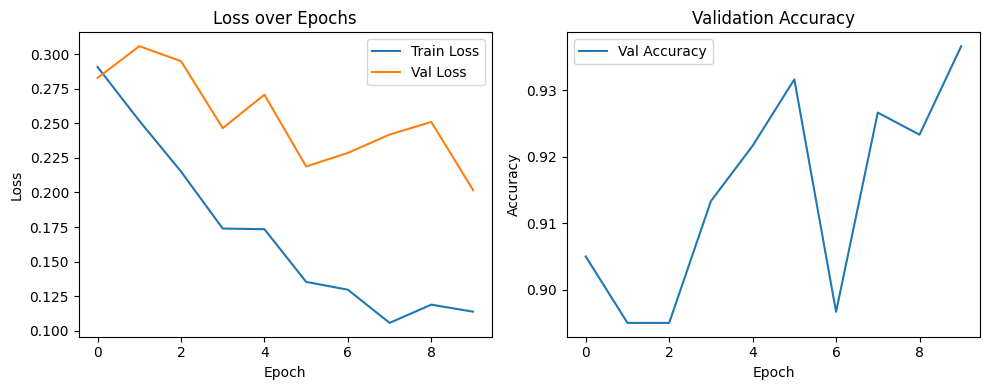

In [19]:
# Построение графиков потерь и точности
plt.figure(figsize=(10, 4))

# Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Оценка на тестовых данных
model_npr.eval()
y_true, y_pred = [], []

# Получение предсказаний
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_npr(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Матрица ошибок и подробный отчет
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
[[171  13   5]
 [  3 190   0]
 [  8   3 189]]

Classification Report:
              precision    recall  f1-score   support

   airplanes       0.94      0.90      0.92       189
        cars       0.92      0.98      0.95       193
        ship       0.97      0.94      0.96       200

    accuracy                           0.95       582
   macro avg       0.95      0.94      0.94       582
weighted avg       0.95      0.95      0.94       582



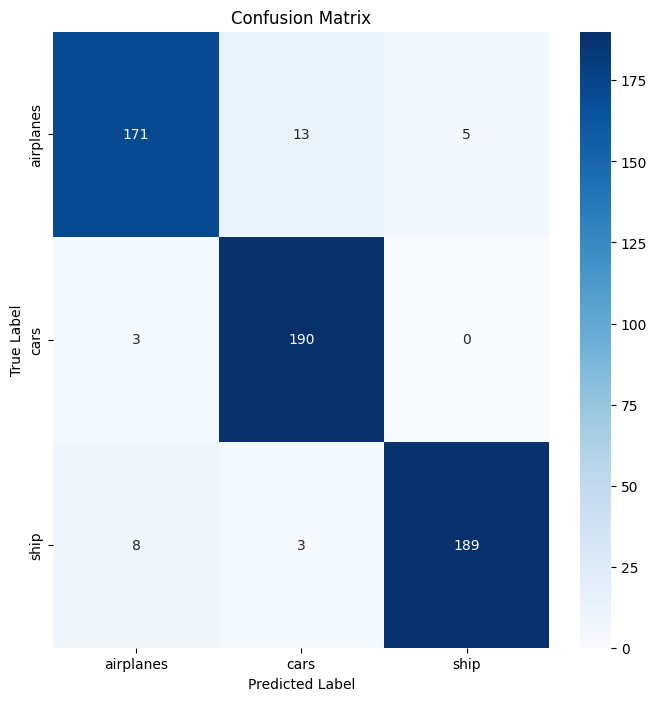

In [23]:
import seaborn as sns

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()